In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import cv2 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from math import sqrt
import cv2
import re
import json

torch.manual_seed(1234)
np.random.seed(1234)

import warnings
warnings.filterwarnings("ignore")

# 1. Data

In [ ]:

def get_data(data_train_path='/content/gdrive/MyDrive/FinalProject/data/task1_train'):
	new_data=[]
	data={}
	for file in os.listdir(data_train_path):
		if re.match('^((?!\)).)*$',file):
			new_data.append(re.sub('.txt|.jpg$','',file))
	codeSet=set(new_data)

	for code in codeSet:
		data[os.path.join(data_train_path,code+'.jpg')]=os.path.join(data_train_path,code+'.txt')

	return data



def save_jsonFile(data):
	with open('/content/gdrive/MyDrive/FinalProject/data/data_task1_train.json','w') as f:
		json.dump(data,f,indent=4)

def read_json_file(path='/content/gdrive/MyDrive/FinalProject/data/data_task1_train.json'):
	with open(path,'r') as f:
		data=json.load(f)
		return data


def show_retangle_from_file(k,v):
	img=cv2.imread(k)
	with open(v,'r') as f:
		for line in f:
			bx=line.split(',')
			x_min=int(bx[0])
			y_min=int(bx[1])
			x_max=int(bx[4])
			y_max=int(bx[5])
			cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255,0), 2)
	plt.imshow(img)
	plt.show()


In [ ]:
# data=get_data()
# save_jsonFile(data)

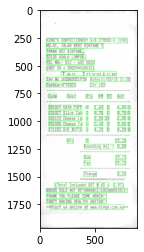

In [ ]:
data=read_json_file()
item=iter(data.items())
next_item=next(item)
show_retangle_from_file(next_item[0],next_item[1])

# 2. Dataset

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:

class my_dataset(Dataset):

    def __init__(self,img_paths,targets_paths):
        self.img_paths=img_paths
        self.targets_paths=targets_paths
        self.transforms=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):

        img=cv2.imread(self.img_paths[idx]) # BGR
        height,width,channels=img.shape
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB
        img=cv2.resize(img,(300,300))
        img=torch.tensor(img, dtype=torch.float32)
        img=img.permute(2, 0, 1) # (height, width, channels) -> (channels, height, width)
        img=self.transforms(img/255)

        tar_path=self.targets_paths[idx]
        with open(tar_path,'r') as f:
            boxes=[]
            labels=[]
            for line in f:
                bx=line.split(',')
                x_min=int(bx[0])
                y_min=int(bx[1])
                x_max=int(bx[4])
                y_max=int(bx[5])
                boxes.append([x_min/width,y_min/height,x_max/width,y_max/height])
                labels.append([0])
            # minmax norm:v
            #boxes_norm=self.normalize(boxes)
            boxes=torch.FloatTensor(boxes)
            
            labels=torch.IntTensor(labels)
            tar=torch.hstack((boxes,labels))
            return img,tar
        
        
def my_collate_fn(batch):
    targets = []
    imgs = []

    for sample in batch:
        imgs.append(sample[0]) #sample[0]=img
        targets.append(sample[1]) # sample[1]=annotation
    #[3, 300, 300]
    # (batch_size, 3, 300, 300)
    imgs = torch.stack(imgs, dim=0)

    return imgs, targets


# 3. Default box 

In [ ]:
cfg = {
    "num_classes": 2,
    "input_size": 300, #SSD300
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4], # Tỷ lệ khung hình cho source1->source6`
    "feature_maps": [38, 19, 10, 5, 3, 1],
    "steps": [8, 16, 32, 64, 100, 300], # Size of default box
    "min_size": [30, 60, 111, 162, 213, 264], # Size of default box
    "max_size": [60, 111, 162, 213, 264, 315], # Size of default box
    "aspect_ratios": [[2], [2,3], [2,3], [2,3], [2], [2]]
}

In [ ]:
import itertools
from math import sqrt


class DefBox():
    def __init__(self, cfg):
        self.img_size = cfg["input_size"]
        self.feature_maps = cfg["feature_maps"]
        self.min_size = cfg["min_size"]
        self.max_size = cfg["max_size"]
        self.aspect_ratios = cfg["aspect_ratios"]
        self.steps = cfg["steps"]

    def create_defbox(self):
        defbox_list = []

        for k, f in enumerate(self.feature_maps):
            for i, j in itertools.product(range(f), repeat=2):
                f_k = self.img_size / self.steps[k]
                cx = (j+0.5)/f_k
                cy = (i+0.5)/f_k

                # small square box 
                s_k = self.min_size[k]/self.img_size #first case: 30/300
                defbox_list += [cx, cy, s_k, s_k]

                # big square box
                s_k_ = sqrt(s_k*(self.max_size[k]/self.img_size))
                defbox_list += [cx, cy, s_k_, s_k_]

                for ar in self.aspect_ratios[k]:
                    defbox_list += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    defbox_list += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
                
        output = torch.Tensor(defbox_list).view(-1, 4)
        output.clamp_(max = 1, min=0)

        return output

In [ ]:
# # test defbox
defbox = DefBox(cfg)
dbox_list = defbox.create_defbox()
print(dbox_list.shape)

torch.Size([8732, 4])


# 4. L2 norm

In [ ]:

class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale
        self.reset_parameters()
        self.eps = 1e-10
    
    def reset_parameters(self):
        nn.init.constant_(self.weight, self.scale)
    
    def forward(self, x):
        # x.size() = (batch_size, chanenel, height, width)
        # L2Norm
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt() + self.eps
        x = torch.div(x, norm)
        #weight.size() = (512) -> (1,512,1,1)
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)

        return weights*x

# 5. MultiBoxLoss

In [ ]:

def intersect(box_a, box_b):
	""" We resize both tensors to [A,B,2] without new malloc:
	[A,2] -> [A,1,2] -> [A,B,2]
	[B,2] -> [1,B,2] -> [A,B,2]
	Then we compute the area of intersect between box_a and box_b.
	Args:
	box_a: (tensor) bounding boxes, Shape: [A,4].
	box_b: (tensor) bounding boxes, Shape: [B,4].
	Return:
	(tensor) intersection area, Shape: [A,B].
	"""
	A = box_a.size(0)
	B = box_b.size(0)
	max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
						box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
	min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
						box_b[:, :2].unsqueeze(0).expand(A, B, 2))
	inter = torch.clamp((max_xy - min_xy), min=0)
	return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
	"""Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
	is simply the intersection over union of two boxes.  Here we operate on
	ground truth boxes and default boxes.
	E.g.:
	    A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
	A	rgs:
	box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
	box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
	Return:
	jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
	"""
	inter = intersect(box_a, box_b)
	area_a = ((box_a[:, 2]-box_a[:, 0]) *
	(box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
	area_b = ((box_b[:, 2]-box_b[:, 0]) *
	(box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
	union = area_a + area_b - inter
	return inter / union  # [A,B]


def point_form(boxes):
	""" Convert prior_boxes to (xmin, ymin, xmax, ymax)
	representation for comparison to point form ground truth data.
	Args:
	boxes: (tensor) center-size default boxes from priorbox layers.
	Return:
	boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
	"""
	return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
					boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax

def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]


# Adapted from https://github.com/Hakuyume/chainer-ssd
def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = torch.cat((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior


In [ ]:
# Jaccard:
# Hard negative mining: negative default box = 3times positve default bos
# Loss in regression task: MSE ->F.SmoothL1Loss
# Loss in classification (multi class): F.CrossEntropy


class MultiBoxLoss(nn.Module):
    def __init__(self, jaccard_threshold=0.5, neg_pos=3, device="cpu"):#  means negative_defautbox_num=neg_pos * positive_one
        super(MultiBoxLoss, self).__init__()
        self.jaccard_threshold = jaccard_threshold
        self.neg_pos = neg_pos
        self.device = device

    def forward(self, predictions, targets):
        loc_data, conf_data, dbox_list = predictions
        # (batch_num, num_dbox, num_classes)  -- loc_data
        num_batch = loc_data.size(0)
        num_dbox = loc_data.size(1)  # 8732
        num_classes = conf_data.size(2)
        # make 2 empty tensors :)
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)  # every dbox has 4 (x_min...,y_max)
        for idx in range(num_batch):
            truths = targets[idx][:, :-1].to(self.device)  # (xmin, ymin, xmax, ymax) BBox
            labels = targets[idx][:, -1].to(self.device)  # label
            dbox = dbox_list.to(self.device)
            variances = [0.1, 0.2]
            match(self.jaccard_threshold, truths, dbox, variances, labels, loc_t, conf_t_label, idx) #--> conf_t_label

        # SmoothL1Loss
        pos_mask = conf_t_label > 0 # positive
        # loc_data(num_batch, 8732, 4)
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # positive dbox, loc_data
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)
        loss_loc = F.smooth_l1_loss(loc_p, loc_t, reduction="sum")

        # loss_conf
        # CrossEntropy
        batch_conf = conf_data.view(-1, num_classes)  # (num_batch*num_box, num_classes)
        loss_conf = F.cross_entropy(batch_conf, conf_t_label.view(-1), reduction="none")

        # hard negative mining
        num_pos = pos_mask.long().sum(1, keepdim=True)
        loss_conf = loss_conf.view(num_batch, -1)  # torch.size([num_batch, 8732])

        _, loss_idx = loss_conf.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)
        # idx_rank chính là thông số để biết được độ lớn loss nằm ở vị trí bao nhiêu

        num_neg = torch.clamp(num_pos * self.neg_pos, max=num_dbox)
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # (num_batch, 8732) -> (num_batch, 8732, 2)
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)
        conf_t_pre = conf_data[(pos_idx_mask + neg_idx_mask).gt(0)].view(-1, num_classes)
        conf_t_label_ = conf_t_label[(pos_mask + neg_mask).gt(0)]
        loss_conf = F.cross_entropy(conf_t_pre, conf_t_label_, reduction="sum")
        # total loss = loss_loc + loss_conf
        N = num_pos.sum()
        loss_loc = loss_loc / N
        loss_conf = loss_conf / N

        return loss_loc, loss_conf

# 6.Model

In [ ]:
from torch.autograd import Function


def create_vgg():
    layers = []
    in_channels = 3

    cfgs = [64, 64, 'M', 128, 128, 'M',
            256, 256, 256, 'MC', 512, 512, 512, 'M',
            512, 512, 512]

    for cfg in cfgs:
        if cfg == 'M': #floor
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif cfg == 'MC': #ceiling
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg, kernel_size=3, padding=1)

            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg
        
    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]

    return nn.ModuleList(layers)


def create_extras():
    layers = []
    in_channels = 1024
    cfgs = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfgs[0], kernel_size=1)]
    layers += [nn.Conv2d(cfgs[0], cfgs[1], kernel_size=3, stride=2, padding=1)]
    layers += [nn.Conv2d(cfgs[1], cfgs[2], kernel_size=1)]
    layers += [nn.Conv2d(cfgs[2], cfgs[3], kernel_size=3, stride=2, padding=1)]
    layers += [nn.Conv2d(cfgs[3], cfgs[4], kernel_size=1)]
    layers += [nn.Conv2d(cfgs[4], cfgs[5], kernel_size=3)]
    layers += [nn.Conv2d(cfgs[5], cfgs[6], kernel_size=1)]
    layers += [nn.Conv2d(cfgs[6], cfgs[7], kernel_size=3)]

    return nn.ModuleList(layers)


def create_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    loc_layers = []
    conf_layers = []

    # source1
    # loc
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]*4, kernel_size=3, padding=1)]
    # conf
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]*num_classes, kernel_size=3, padding=1)]

    #source2
    #loc
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]*4, kernel_size=3, padding=1)]
    #conf
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]*num_classes, kernel_size=3, padding=1)]

    #source3
    #loc
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]*4, kernel_size=3, padding=1)]
    #conf 
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]*num_classes, kernel_size=3, padding=1)]

    #source4
    #loc
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]*4, kernel_size=3, padding=1)]
    #conf 
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]*num_classes, kernel_size=3, padding=1)]

    #source5
    #loc
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]*4, kernel_size=3, padding=1)]
    #conf 
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]*num_classes, kernel_size=3, padding=1)]

    #source6
    #loc
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]*4, kernel_size=3, padding=1)]
    #conf 
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]*num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)




class SSD(nn.Module):
    def __init__(self, phase, cfg):
        super(SSD, self).__init__()
        self.phase = phase
        self.num_classes= cfg["num_classes"]

        #create main modules
        self.vgg = create_vgg()
        self.extras = create_extras()
        self.loc, self.conf = create_loc_conf(cfg["num_classes"], cfg["bbox_aspect_num"])
        self.L2Norm = L2Norm()

        #create default box
        dbox = DefBox(cfg)
        self.dbox_list = dbox.create_defbox()

        if phase == "inference":
            self.detect = Detect()

    def forward(self, x):
        sources = list()
        loc = list()
        conf = list()

        for k in range(23):
            x = self.vgg[k](x)
        
        # source1
        source1 = self.L2Norm(x)
        sources.append(source1)

        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)
        # source2
        sources.append(x)

        # source3~6
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k %2 == 1:
                sources.append(x)
        

        for (x, l, c) in zip(sources, self.loc, self.conf):
            # aspect_ratio_num = 4, 6
            # (batch_size, 4*aspect_ratio_num, featuremap_height, featuremap_width)
            # -> (batch_size, featuremap_height, featuremap_width ,4*aspect_ratio_num)
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1) #(batch_size, 34928) 4*8732
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1) #(batch_size, 8732*2)

        loc = loc.view(loc.size(0), -1, 4) #(batch_size, 8732, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes) #(batch_size, 8732, 2)

        output = (loc, conf, self.dbox_list)  # prediction

        if self.phase == "inference":
            return self.detect(output[0], output[1], output[2])
        else:
            return output


def decode(loc, defbox_list):
    """
    parameters:
    loc: [8732, 4] (delta_x, delta_y, delta_w, delta_h)
    defbox_list: [8732, 4] (cx_d, cy_d, w_d, h_d)
    returns:
    boxes [xmin, ymin, xmax, ymax]
    """

    boxes = torch.cat((
        defbox_list[:, :2] + 0.1*loc[:, :2]*defbox_list[:, 2:],
        defbox_list[:, 2:]*torch.exp(loc[:,2:]*0.2)), dim=1)

    boxes[:, :2] -= boxes[:,2:]/2 #calculate xmin, ymin
    boxes[:, 2:] += boxes[:, :2] #calculate xmax, ymax

    return boxes


# non-maximum_supression
def nms(boxes, scores, overlap=0.45, top_k=200):
    """
    boxes: [num_box, 4]
    scores: [num_box]
    """
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()

    # boxes coordinate
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # area of boxes
    area = torch.mul(x2-x1, y2-y1)

    tmp_x1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    value, idx = scores.sort(0)
    idx = idx[-top_k:] # id của top 200 boxes có độ tự tin cao nhất

    while idx.numel() > 0:
        i = idx[-1] # id của box có độ tự tin cao nhất
        keep[count] = i
        count += 1

        if idx.size(0) == 1:
            break
        
        idx = idx[:-1] #id của boxes ngoại trừ box có độ tự tin cao nhất
        #information boxes
        torch.index_select(x1, 0, idx, out=tmp_x1) #x1
        torch.index_select(y1, 0, idx, out=tmp_y1) #y1
        torch.index_select(x2, 0, idx, out=tmp_x2) #x2
        torch.index_select(y2, 0, idx, out=tmp_y2) #y2

        tmp_x1 = torch.clamp(tmp_x1, min=x1[i]) # =x1[i] if tmp_x1 < x1[1]
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i]) # =y2[i] if tmp_y2 > y2[i]
        
        # chuyển về tensor có size mà index được giảm đi 1
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # overlap area
        inter = tmp_w*tmp_h
        others_area = torch.index_select(area, 0, idx) # diện tích của mỗi bbox
        union = area[i] + others_area - inter
        iou = inter/union
        idx = idx[iou.le(overlap)] # giữ lại id của box có overlap ít với bbox đang xét

    return keep, count


class Detect(Function):
    def __init__(self, conf_thresh=0.01, top_k=200, nsm_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh
        self.top_k = top_k
        self.nms_thresh = nsm_thresh
    
    def __call__(self, loc_data, conf_data, dbox_list):
      return self.forward(loc_data, conf_data, dbox_list)
      
    def forward(self, loc_data, conf_data, dbox_list):
        num_batch = loc_data.size(0) #batch_size 
        num_dbox = loc_data.size(1) # 8732
        num_classe = conf_data.size(2) #2

        conf_data = self.softmax(conf_data) 
        # (batch_num, num_dbox, num_class) -> (batch_num, num_class, num_dbox)
        conf_preds = conf_data.transpose(2, 1)

        output = torch.zeros(num_batch, num_classe, self.top_k, 5)

        # xử lý từng bức ảnh trong một batch các bức ảnh
        for i in range(num_batch):
            # Tính bbox từ offset information và default box
            decode_boxes = decode(loc_data[i], dbox_list)

            # copy confidence score của ảnh thứ i
            conf_scores = conf_preds[i].clone()

            for cl in range(1, num_classe):
                c_mask = conf_scores[cl].gt(self.conf_thresh) # chỉ lấy những confidence > 0.01
                scores = conf_scores[cl][c_mask]
                if scores.nelement() == 0: #numel()
                    continue

                # đưa chiều về giống chiều của decode_boxes để tính toán
                l_mask = c_mask.unsqueeze(1).expand_as(decode_boxes) #(8732, 4)
                boxes = decode_boxes[l_mask].view(-1, 4) # (số box có độ tự tin lớn hơn > 0.01, 4)
                ids, count = nms(boxes, scores, self.nms_thresh, self.top_k)
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1), boxes[ids[:count]]), 1)

        return output

In [ ]:
# test model

# vgg = create_vgg()
# print(vgg)
# extras = create_extras()
# print(extras)
# loc, conf = create_loc_conf()
# print(loc)
# print(conf)
ssd = SSD(phase="train", cfg=cfg)
print(ssd)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

# 7. Train

In [ ]:
from sklearn import model_selection
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
torch.backends.cudnn.benchmark = True

device: cuda:0


In [ ]:
data=read_json_file()
img_paths = list(data.keys())
targets_paths = list(data.values())
## split
X_train, X_val, y_train, y_val = model_selection.train_test_split(img_paths, targets_paths, test_size=0.2, random_state=1)

train_dataset = my_dataset(img_paths,targets_paths)
val_dataset = my_dataset(X_val,y_val)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=my_collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, collate_fn=my_collate_fn)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}


In [ ]:
net = SSD(phase="train", cfg=cfg)


In [ ]:
#pretrain
vgg_weights = torch.load("/content/gdrive/MyDrive/FinalProject/task1/pretrained/vgg16_reducedfc.pth")
net.vgg.load_state_dict(vgg_weights)

net_weights = torch.load("/content/gdrive/MyDrive/FinalProject/task1/ssd300_.pth")
net.load_state_dict(net_weights)


<All keys matched successfully>

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# He init
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

ModuleList(
  (0): Conv2d(512, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:

# MultiBoxLoss
criterion = MultiBoxLoss(jaccard_threshold=0.5, neg_pos=3, device=device)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, weight_decay=5e-4)


In [ ]:

# training, validation
def train_model(net, dataloader_dict, criterion, optimizer, num_epochs):
    # move network to GPU
    net.to(device)
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    val_loss=[]
    logs = []
    best_val_loss=999999
    print("Training...")
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
              net.train()
    
              for images, targets in dataloader_dict['train']:
                  # move to GPU or not!
                  images = images.to(device)
                  targets = [ann.to(device) for ann in targets]

                  # init optimizer
                  optimizer.zero_grad()
                  # forward
                  with torch.set_grad_enabled(phase=="train"):
                    outputs = net(images)
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c 
                    loss.backward() # calculate gradient
                    nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                    optimizer.step() # update parameters
                    epoch_train_loss += loss.item()
                    
            else:
              net.eval()
             
              for images, targets in dataloader_dict['val']:
                images = images.to(device)
                targets = [ann.to(device) for ann in targets]
                outputs = net(images)
                loss_l, loss_c = criterion(outputs, targets)
                loss = loss_l + loss_c # alpha=1
                epoch_val_loss += loss.item()
        print("---"*20)
        print("Epoch {} || epoch_train_loss: {:.4f} || Epoch_val_loss: {:.4f}".format(epoch+1, epoch_train_loss, epoch_val_loss))           
        log_epoch = {"epoch": epoch+1, "train_loss": epoch_train_loss, "val_loss": epoch_val_loss}
        logs.append(log_epoch)
        val_loss.append(epoch_val_loss)
        df = pd.DataFrame(logs)
        df.to_csv("/content/gdrive/MyDrive/FinalProject/task1/ssd_logs.csv")
        torch.save(net.state_dict(), "/content/gdrive/MyDrive/FinalProject/task1/ssd300_" + ".pth")
        if epoch_val_loss<best_val_loss:
            best_val_loss=epoch_val_loss
            torch.save(net.state_dict(), "/content/gdrive/MyDrive/FinalProject/task1/ssd300_best_val" + ".pth")
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0
            

In [ ]:
num_epochs = 25
train_model(net, dataloader_dict, criterion, optimizer, num_epochs=num_epochs)

Training...
------------------------------------------------------------
Epoch 1 || epoch_train_loss: 63.5789 || Epoch_val_loss: 4.4756
------------------------------------------------------------
Epoch 2 || epoch_train_loss: 18.8448 || Epoch_val_loss: 3.1512
------------------------------------------------------------
Epoch 3 || epoch_train_loss: 14.1013 || Epoch_val_loss: 2.4410
------------------------------------------------------------
Epoch 4 || epoch_train_loss: 12.5803 || Epoch_val_loss: 2.3403
------------------------------------------------------------
Epoch 5 || epoch_train_loss: 12.2601 || Epoch_val_loss: 2.4466
------------------------------------------------------------
Epoch 6 || epoch_train_loss: 11.3259 || Epoch_val_loss: 2.1167
------------------------------------------------------------
Epoch 7 || epoch_train_loss: 11.6219 || Epoch_val_loss: 2.0890
------------------------------------------------------------
Epoch 8 || epoch_train_loss: 11.9025 || Epoch_val_loss: 2.2

# 8. Inference

In [ ]:
net = SSD(phase="inference", cfg=cfg)
net_weights = torch.load("/content/gdrive/MyDrive/FinalProject/task1/ssd300_best_val.pth")
net.load_state_dict(net_weights)

<All keys matched successfully>

In [ ]:


def show_predict(img_file_path):
    img = cv2.imread(img_file_path)
    img_= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_=cv2.resize(img_,(300,300))
    img_=torch.tensor(img_, dtype=torch.float32)

    img_=img_.permute(2, 0, 1)
    transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    img_=transform(img_/255)
    with torch.no_grad():
      net.eval()
      input = img_.unsqueeze(0)#(1, 3, 300, 300)

      output = net(input)
      #print(output)
      
      colors = [(255,0,0), (0,255,0), (0,0,255)]
      font = cv2.FONT_HERSHEY_SIMPLEX

      detections = output.data #(1, 2, 200, 5) 1 img, 2 classes, 5: score, cx, cy, w, h, 200 bdx each class
    
      scale = torch.Tensor(img.shape[1::-1]).repeat(2)  # 

      for i in range(detections.size(1)):
          j = 0
          while detections[0, i, j, 0] >= 0.9:
              score = detections[0, i, j, 0]
              print(score)
              pt = (detections[0, i, j, 1:]*scale).numpy()
             
              cv2.rectangle(img,
                            (int(pt[0]), int(pt[1])),
                            (int(pt[2]), int(pt[3])),
                            colors[i%3], 2
                            )
              #display_text = "%.2f"%(score)
              j += 1
          print(j)
      plt.figure(figsize=(20, 20))
      plt.imshow(img)
      plt.show()

0
tensor(1.)
tensor(1.)
tensor(1.0000)
tensor(1.0000)
tensor(0.9994)
tensor(0.9990)
tensor(0.9932)
tensor(0.9882)
tensor(0.9863)
tensor(0.9732)
tensor(0.9686)
tensor(0.9323)
tensor(0.9249)
tensor(0.9238)
14


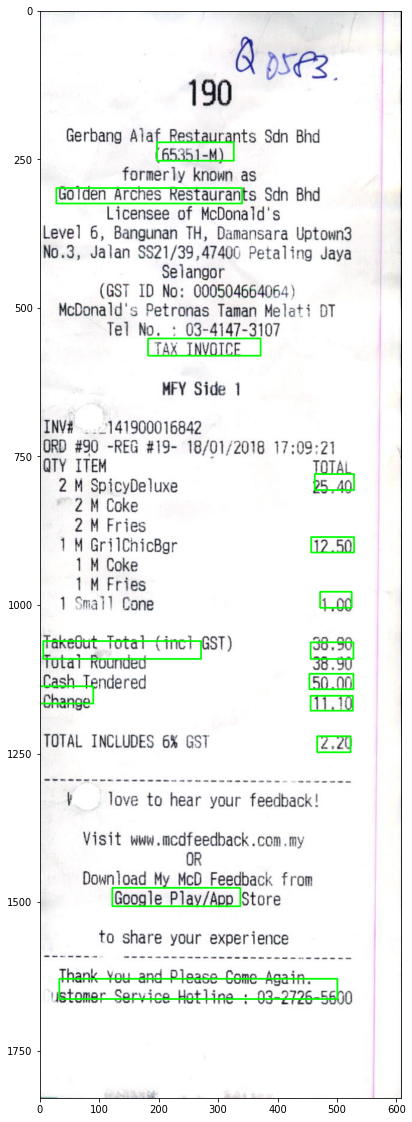

In [ ]:

test_dir='/content/gdrive/MyDrive/FinalProject/data/task12_test'
test_paths=os.listdir(test_dir)
test_paths_=[os.path.join(test_dir,x) for x in test_paths]
img_file_path = test_paths_[8]
show_predict(img_file_path)

# 9. EasyOCR

In [ ]:
!pip install easyocr

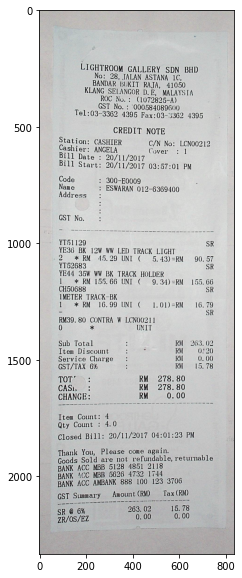

In [ ]:
# test img
img=cv2.imread(img_file_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

In [ ]:
import easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext(img_file_path)


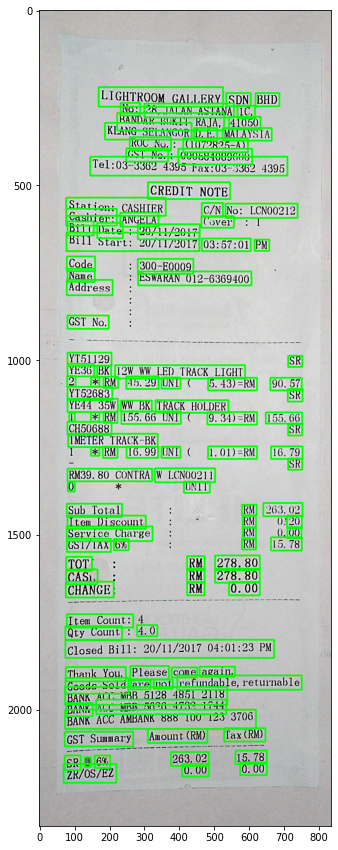

In [ ]:
spacer = 100
font = cv2.FONT_HERSHEY_SIMPLEX
for detection in result: 
    top_left = (int(detection[0][0][0]),int(detection[0][0][1]))
    bottom_right = (int(detection[0][2][0]),int(detection[0][2][1]))
    text = detection[1]
    img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
    #img = cv2.putText(img,text,(20,spacer), font, 0.5,(0,255,0),2,cv2.LINE_AA)
    spacer+=15
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()